In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import matplotlib.pyplot as plt
import numpy as np
import pickle

os.chdir('/Users/lucreziavaleriani/Documents/GitHub/LOCATE/')

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from simulations.simulations import simulate_segment, simulate_data

In [45]:
segs = simulate_segment(only_clonal = True)
snp,snv = simulate_data(segs)

In [59]:
clonal_seg = list(set(snp.loc[snp.CN_1 == '1:1'].segID))[0]
data_input = snp.loc[snp.segID == clonal_seg]
data_input = {'baf':torch.tensor(np.array(data_input['baf']).reshape(-1, 1)), 
              'dr':torch.tensor(np.array(data_input['dr']).reshape(-1, 1))}

In [55]:
# with open('./data/data.pkl', 'rb') as data:
#     data_input = pickle.load(data)

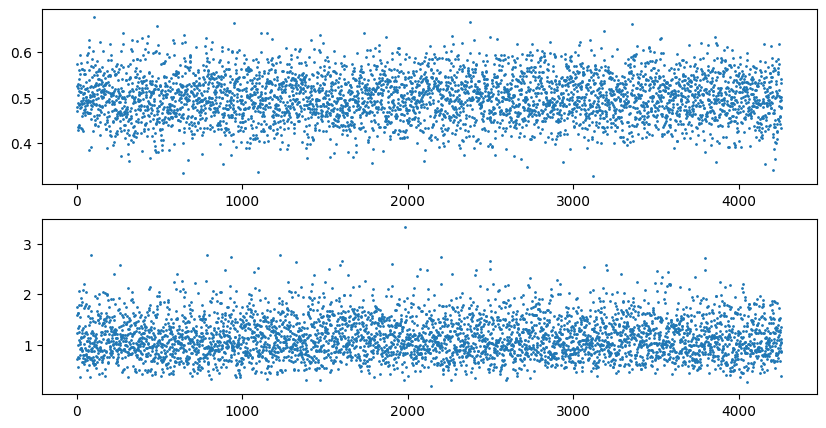

In [60]:
fig, axs = plt.subplots(2, figsize=(10, 5))
axs[0].plot(range(len(data_input['baf'])), data_input['baf'], 'o', markersize = 1)
axs[1].plot(range(len(data_input['dr'])), data_input['dr'], 'o', markersize = 1)

In [61]:
import locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [62]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"], "dr": data_input["dr"], "vaf": None})
locate.set_model_params({"jumping_prob" : 1e-6})

In [7]:
ll = locate.run(steps = 300, param_optimizer = {"lr" : 0.1})

KeyError: 'ploidy'

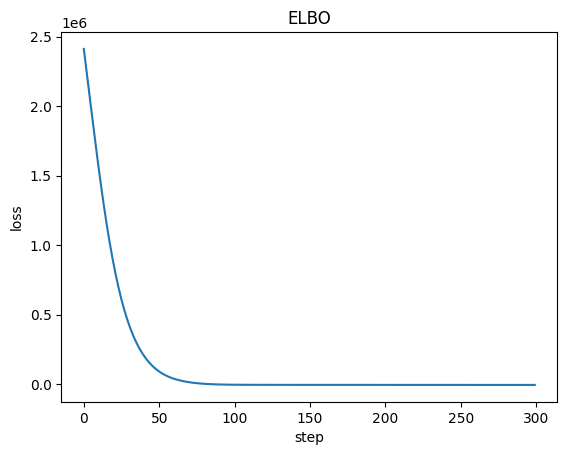

In [ ]:
plot_loss(ll[0])

In [ ]:
bau = locate.learned_parameters()

In [ ]:
print(bau['baf_n_trial'], bau['dr_n_trial'])

35.54332 1.0001553


In [ ]:
bau['probs_x']

array([[1.0000000e+00, 4.1501655e-13, 2.0859102e-10, 4.2441051e-13,
        2.0394895e-12],
       [2.0324401e-28, 1.0000000e+00, 2.5746022e-28, 2.5746022e-28,
        2.5746022e-28],
       [6.4513092e-14, 1.4224480e-14, 1.0000000e+00, 1.5130477e-14,
        1.4226923e-14],
       [7.2148461e-19, 1.0090495e-18, 1.0000000e+00, 2.0141501e-11,
        1.0090495e-18],
       [2.0324401e-28, 2.5746022e-28, 2.5746022e-28, 2.5746022e-28,
        1.0000000e+00]], dtype=float32)

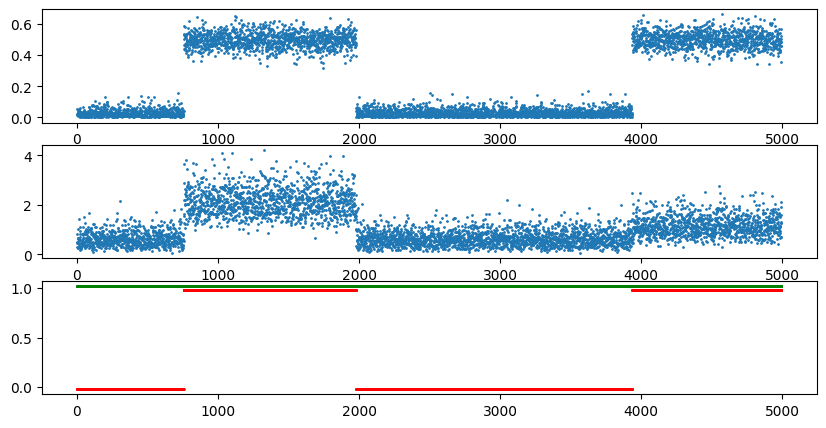

In [ ]:
fig, axs = plt.subplots(3, figsize=(10, 5))
axs[0].plot(range(len(bau["CN_Major"])), data_input["baf"], 'o',  markersize = 1)
axs[1].plot(range(len(bau["CN_Major"])), data_input["dr"], 'o',  markersize = 1)
axs[2].plot(range(len(bau["CN_Major"])), bau["CN_Major"] + 0.02, 'o', color='green', markersize = 1)
axs[2].plot(range(len(bau["CN_minor"])), bau["CN_minor"] - 0.02, 'o', color='red', markersize = 1)